# 第3章 线性分类

分类是机器学习中最常见的一类任务，其预测标签是一些离散的类别（符号）。根据分类任务的类别数量又可以分为二分类任务和多分类任务。

线性分类是指利用一个或多个线性函数将样本进行分类。常用的线性分类模型有Logistic回归和Softmax回归。
Logistic回归是一种常用的处理二分类问题的线性模型。Softmax回归是Logistic回归在多分类问题上的推广。

在学习本章内容前，建议您先阅读《神经网络与深度学习》第3章：线性模型的相关内容，关键知识点如 **图3.1** 所示，以便更好的理解和掌握相应的理论知识，及其在实践中的应用方法。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/797cd285fbb14112944378971ddf402a7a7f3d8fdc41461ebd4373b3770a3b46" width=400></center>
<br><center>图3.1 线性模型关键知识点回顾</center></br>

本章内容基于 **《神经网络与深度学习》第3章：线性模型** 相关内容进行设计，主要包含两部分：

* **模型解读**：介绍两个最常用的线性分类模型Logistic回归和Softmax回归的原理剖析和相应的代码实现。通过理论和代码的结合，加深对线性模型的理解；

* **案例实践**：基于Softmax回归算法完成鸢尾花分类任务。

## 3.1 基于Logistic回归的二分类任务

在本节中，我们实现一个Logistic回归模型，并对一个简单的数据集进行二分类实验。

### 3.1.1 数据集构建

我们首先构建一个简单的分类任务，并构建训练集、验证集和测试集。
本任务的数据来自带噪音的两个弯月形状函数，每个弯月对一个类别。我们采集1000条样本，每个样本包含2个特征。

数据集的构建函数`make_moons`的代码实现如下：

In [1]:
import math
import copy
import paddle

def make_moons(n_samples=1000, shuffle=True, noise=None):
    """
    生成带噪音的弯月形状数据
    输入：
        - n_samples：数据量大小，数据类型为int
        - shuffle：是否打乱数据，数据类型为bool
        - noise：以多大的程度增加噪声，数据类型为None或float，noise为None时表示不增加噪声
    输出：
        - X：特征数据，shape=[n_samples,2]
        - y：标签数据, shape=[n_samples]
    """
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    # 采集第1类数据，特征为(x,y)
    # 使用'paddle.linspace'在0到pi上均匀取n_samples_out个值
    # 使用'paddle.cos'计算上述取值的余弦值作为特征1，使用'paddle.sin'计算上述取值的正弦值作为特征2
    outer_circ_x = paddle.cos(paddle.linspace(0, math.pi, n_samples_out))
    outer_circ_y = paddle.sin(paddle.linspace(0, math.pi, n_samples_out))

    inner_circ_x = 1 - paddle.cos(paddle.linspace(0, math.pi, n_samples_in))
    inner_circ_y = 0.5 - paddle.sin(paddle.linspace(0, math.pi, n_samples_in))
    
    print('outer_circ_x.shape:', outer_circ_x.shape, 'outer_circ_y.shape:', outer_circ_y.shape)
    print('inner_circ_x.shape:', inner_circ_x.shape, 'inner_circ_y.shape:', inner_circ_y.shape)
    
    # 使用'paddle.concat'将两类数据的特征1和特征2分别延维度0拼接在一起，得到全部特征1和特征2
    # 使用'paddle.stack'将两类特征延维度1堆叠在一起
    X = paddle.stack(
        [paddle.concat([outer_circ_x, inner_circ_x]),
        paddle.concat([outer_circ_y, inner_circ_y])],
        axis=1
    )

    print('after concat shape:', paddle.concat([outer_circ_x, inner_circ_x]).shape)
    print('X shape:', X.shape)

    # 使用'paddle. zeros'将第一类数据的标签全部设置为0
    # 使用'paddle. ones'将第一类数据的标签全部设置为1
    y = paddle.concat(
        [paddle.zeros(shape=[n_samples_out]), paddle.ones(shape=[n_samples_in])]
    )

    print('y shape:', y.shape)

    # 如果shuffle为True，将所有数据打乱
    if shuffle:
        # 使用'paddle.randperm'生成一个数值在0到X.shape[0]，随机排列的一维Tensor做索引值，用于打乱数据
        idx = paddle.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]

    # 如果noise不为None，则给特征值加入噪声
    if noise is not None:
        # 使用'paddle.normal'生成符合正态分布的随机Tensor作为噪声，并加到原始特征上
        X += paddle.normal(mean=0.0, std=noise, shape=X.shape)

    return X, y

随机采集1000个样本，并进行可视化。

outer_circ_x.shape: [500] outer_circ_y.shape: [500]
inner_circ_x.shape: [500] inner_circ_y.shape: [500]
after concat shape: [1000]
X shape: [1000, 2]
y shape: [1000]


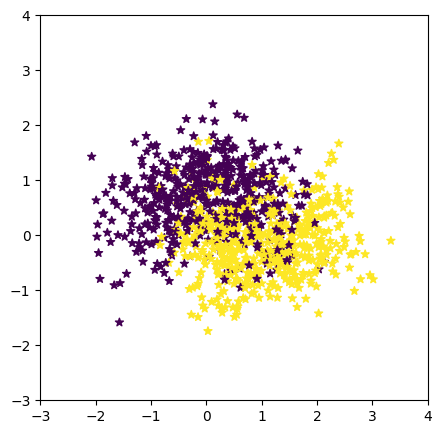

In [5]:
# 采样1000个样本
n_samples = 1000
X, y = make_moons(n_samples=n_samples, shuffle=True, noise=0.5)
# 可视化生产的数据集，不同颜色代表不同类别
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(x=X[:, 0].tolist(), y=X[:, 1].tolist(), marker='*', c=y.tolist())
plt.xlim(-3,4)
plt.ylim(-3,4)
plt.savefig('linear-dataset-vis.pdf')
plt.show()



将1000条样本数据拆分成训练集、验证集和测试集，其中训练集640条、验证集160条、测试集200条。代码实现如下：

In [6]:
num_train = 640
num_dev = 160
num_test = 200

X_train, y_train = X[:num_train], y[:num_train]
X_dev, y_dev = X[num_train:num_train + num_dev], y[num_train:num_train + num_dev]
X_test, y_test = X[num_train + num_dev:], y[num_train + num_dev:]

y_train = y_train.reshape([-1,1])
y_dev = y_dev.reshape([-1,1])
y_test = y_test.reshape([-1,1])

这样，我们就完成了Moon1000数据集的构建。

In [7]:
# 打印X_train和y_train的维度
print("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)

X_train shape:  [640, 2] y_train shape:  [640, 1]


In [8]:
# 打印一下前5个数据的标签
print(X_train[:5])
print (y_train[:5])

Tensor(shape=[5, 2], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[ 1.05707848,  1.09546852],
        [ 2.05914140, -0.37111807],
        [ 1.04530180, -0.37622443],
        [-0.03245860,  0.84677267],
        [ 1.00109148, -0.87520587]])
Tensor(shape=[5, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.],
        [1.],
        [1.],
        [0.],
        [1.]])


### 3.1.2 模型构建

Logistic回归是一种常用的处理二分类问题的线性模型。与线性回归一样，Logistic回归也会将输入特征与权重做线性叠加。不同之处在于，Logistic回归引入了非线性函数$g:\mathbb{R}^D \rightarrow (0,1)$，预测类别标签的后验概率 $p(y=1|\mathbf x)$ ，从而解决连续的线性函数不适合进行分类的问题。

$$
p(y=1|\mathbf x) = \sigma(\mathbf w^ \mathrm{ T } \mathbf x+b),（3.1）
$$

其中判别函数$\sigma(\cdot)$为Logistic函数，也称为激活函数，作用是将线性函数$f(\mathbf x;\mathbf w,b)$的输出从实数区间“挤压”到（0,1）之间，用来表示概率。Logistic函数定义为：

$$
\sigma(x) = \frac{1}{1+\exp(-x)}。（3.2）
$$

**Logistic函数**

Logistic函数的代码实现如下：

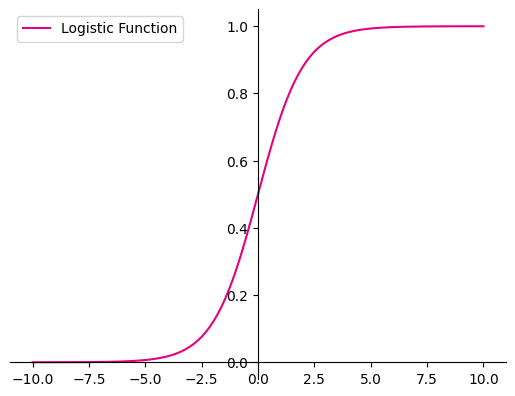

In [13]:
# 定义Logistic函数
def logistic(x):
    return 1 / (1 + paddle.exp(-x))

# 在[-10,10]的范围内生成一系列的输入值，用于绘制函数曲线
x = paddle.linspace(-10, 10, 10000)
plt.figure()
plt.plot(x.tolist(), logistic(x).tolist(), color="#e4007f", label="Logistic Function")
# 设置坐标轴
ax = plt.gca()
# 取消右侧和上侧坐标轴
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
# 设置默认的x轴和y轴方向
ax.xaxis.set_ticks_position('bottom') 
ax.yaxis.set_ticks_position('left')
# 设置坐标原点为(0,0)
ax.spines['left'].set_position(('data',0))
ax.spines['bottom'].set_position(('data',0))
# 添加图例
plt.legend()
plt.savefig('linear-logistic.pdf')
plt.show()

从输出结果看，当输入在0附近时，Logistic函数近似为线性函数；而当输入值非常大或非常小时，函数会对输入进行抑制。输入越小，则越接近0；输入越大，则越接近1。正因为Logistic函数具有这样的性质，使得其输出可以直接看作为概率分布。

**Logistic回归算子**

Logistic回归模型其实就是线性层与Logistic函数的组合，通常会将 Logistic回归模型中的权重和偏置初始化为0，同时，为了提高预测样本的效率，我们将$N$个样本归为一组进行成批地预测。

$$
\hat{\mathbf y} = p(\mathbf y|\mathbf x) = \sigma(\boldsymbol{X} \boldsymbol{w} + b), (3.3)
$$

其中$\boldsymbol{X}\in \mathbb{R}^{N\times D}$为$N$个样本的特征矩阵，$\hat{\boldsymbol{y}}$为$N$个样本的预测值构成的$N$维向量。

这里，我们构建一个Logistic回归算子，代码实现如下：

In [14]:
from nndl import op

class model_LR(op.Op):
    def __init__(self, input_dim):
        super(model_LR, self).__init__()
        self.params = {}
        # 将线性层的权重参数全部初始化为0
        self.params['w'] = paddle.zeros(shape=[input_dim, 1])
        # self.params['w'] = paddle.normal(mean=0, std=0.01, shape=[input_dim, 1])
        # 将线性层的偏置参数初始化为0
        self.params['b'] = paddle.zeros(shape=[1])

    def __call__(self, inputs):
        return self.forward(inputs)

    def forward(self, inputs):
        """
        输入：
            - inputs: shape=[N,D], N是样本数量，D为特征维度
        输出：
            - outputs：预测标签为1的概率，shape=[N,1]
        """
        # 线性计算
        score = paddle.matmul(inputs, self.params['w']) + self.params['b']
        # Logistic 函数
        outputs = logistic(score)
        return outputs

**测试一下**

随机生成3条长度为4的数据输入Logistic回归模型，观察输出结果。

In [15]:
# 固定随机种子，保持每次运行结果一致
paddle.seed(0)
# 随机生成3条长度为4的数据
inputs = paddle.randn(shape=[3,4])
print('Input is:', inputs)
# 实例化模型
model = model_LR(4)
outputs = model(inputs)
print('Output is:', outputs)

Input is: Tensor(shape=[3, 4], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[-0.92466241, -0.42534423, -2.64384580,  0.14518386],
        [-0.12086640, -0.57972574, -0.62285101, -0.32838690],
        [-1.07454193, -0.36314395, -1.67105043,  2.26550484]])
Output is: Tensor(shape=[3, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.50000000],
        [0.50000000],
        [0.50000000]])


从输出结果看，模型最终的输出$g(·)$恒为0.5。这是由于采用全0初始化后，不论输入值的大小为多少，Logistic函数的输入值恒为0，因此输出恒为0.5。

### 3.1.3 损失函数

在模型训练过程中，需要使用损失函数来量化预测值和真实值之间的差异。
给定一个分类任务，$\mathbf y$表示样本$\mathbf x$的标签的真实概率分布，向量$\hat{\mathbf y}=p(\mathbf y|\mathbf x)$表示预测的标签概率分布。
训练目标是使得$\hat{\mathbf y}$尽可能地接近$\mathbf y$，通常可以使用**交叉熵损失函数**。
在给定$\mathbf y$的情况下，如果预测的概率分布$\hat{\mathbf y}$与标签真实的分布$\mathbf y$越接近，则交叉熵越小；如果$p(\mathbf x)$和$\mathbf y$越远，交叉熵就越大。

对于二分类任务，我们只需要计算$\hat{y}=p(y=1|\mathbf x)$，用$1-\hat{y}$来表示$p(y=0|\mathbf x)$。
给定有$N$个训练样本的训练集$\{(\mathbf x^{(n)},y^{(n)})\} ^N_{n=1}$，使用交叉熵损失函数，Logistic回归的风险函数计算方式为：


$$
\begin{aligned}
\cal R(\mathbf w,b) &= -\frac{1}{N}\sum_{n=1}^N \Big(y^{(n)}\log\hat{y}^{(n)} + (1-y^{(n)})\log(1-\hat{y}^{(n)})\Big)。（3.4）
\end{aligned}
$$

向量形式可以表示为：

$$
\begin{aligned}
\cal R(\mathbf w,b) &= -\frac{1}{N}\Big(\mathbf y^ \mathrm{ T }  \log\hat{\mathbf y} + (1-\mathbf y)^ \mathrm{ T } \log(1-\hat{\mathbf y})\Big),（3.5）
\end{aligned}
$$

其中$\mathbf y\in [0,1]^N$为$N$个样本的真实标签构成的$N$维向量，$\hat{\mathbf y}$为$N$个样本标签为1的后验概率构成的$N$维向量。

二分类任务的交叉熵损失函数的代码实现如下：

In [16]:
# 实现交叉熵损失函数
class BinaryCrossEntropyLoss(op.Op):
    def __init__(self):
        self.predicts = None
        self.labels = None
        self.num = None

    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)

    def forward(self, predicts, labels):
        """
        输入：
            - predicts：预测值，shape=[N, 1]，N为样本数量
            - labels：真实标签，shape=[N, 1]
        输出：
            - 损失值：shape=[1]
        """
        self.predicts = predicts
        self.labels = labels
        self.num = self.predicts.shape[0]
        loss = -1. / self.num * (paddle.matmul(self.labels.t(), paddle.log(self.predicts)) + paddle.matmul((1-self.labels.t()), paddle.log(1-self.predicts)))
        loss = paddle.squeeze(loss, axis=1)
        return loss

# 测试一下
# 生成一组长度为3，值为1的标签数据
labels = paddle.ones(shape=[3,1])
# 计算风险函数
bce_loss = BinaryCrossEntropyLoss()
print(bce_loss(outputs, labels))

Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.69314718])


### 3.1.4 模型优化

不同于线性回归中直接使用最小二乘法即可进行模型参数的求解，Logistic回归需要使用优化算法对模型参数进行有限次地迭代来获取更优的模型，从而尽可能地降低风险函数的值。
在机器学习任务中，最简单、常用的优化算法是梯度下降法。

使用梯度下降法进行模型优化，首先需要初始化参数$\mathbf W$和 $b$，然后不断地计算它们的梯度，并沿梯度的反方向更新参数。

#### 3.1.4.1 梯度计算

在Logistic回归中，风险函数$\cal R(\mathbf w,b)$ 关于参数$\mathbf w$和$b$的偏导数为：

$$
\begin{aligned}
\frac{\partial \cal R(\mathbf w,b)}{\partial \mathbf w} = -\frac{1}{N}\sum_{n=1}^N \mathbf x^{(n)}(y^{(n)}- \hat{y}^{(n)}) = -\frac{1}{N} \mathbf X^ \mathrm{ T }  (\mathbf y-\hat{\mathbf y})
\end{aligned}，（3.6）
$$

$$
\begin{aligned}
\frac{\partial \cal R(\mathbf w,b)}{\partial b} = -\frac{1}{N}\sum_{n=1}^N (y^{(n)}- \hat{y}^{(n)}) = -\frac{1}{N} \mathbf {sum}(\mathbf y-\hat{\mathbf y})
\end{aligned}。（3.7）
$$

通常将偏导数的计算过程定义在Logistic回归算子的`backward`函数中，代码实现如下:

In [17]:
class model_LR(op.Op):
    def __init__(self, input_dim):
        super(model_LR, self).__init__()
        # 存放线性层参数
        self.params = {}
        # 将线性层的权重参数全部初始化为0
        self.params['w'] = paddle.zeros(shape=[input_dim, 1])
        # self.params['w'] = paddle.normal(mean=0, std=0.01, shape=[input_dim, 1])
        # 将线性层的偏置参数初始化为0
        self.params['b'] = paddle.zeros(shape=[1])
        # 存放参数的梯度
        self.grads = {}
        self.X = None
        self.outputs = None

    def __call__(self, inputs):
        return self.forward(inputs)

    def forward(self, inputs):
        self.X = inputs
        # 线性计算
        score = paddle.matmul(inputs, self.params['w']) + self.params['b']
        # Logistic 函数
        self.outputs = logistic(score)
        return self.outputs

    def backward(self, labels):
        """
        输入：
            - labels：真实标签，shape=[N, 1]
        """
        N = labels.shape[0]
        # 计算偏导数
        self.grads['w'] = -1 / N * paddle.matmul(self.X.t(), (labels - self.outputs))
        self.grads['b'] = -1 / N * paddle.sum(labels - self.outputs)

#### 3.1.4.2 参数更新

在计算参数的梯度之后，我们按照下面公式更新参数：

$$
\mathbf w\leftarrow \mathbf w - \alpha \frac{\partial \cal R(\mathbf w,b)}{\partial \mathbf w}，（3.8）
$$
$$
b\leftarrow b - \alpha \frac{\partial \cal R(\mathbf w,b)}{\partial b}，（3.9）
$$

其中$\alpha$ 为学习率。

将上面的参数更新过程包装为优化器，首先定义一个优化器基类`Optimizer`，方便后续所有的优化器调用。在这个基类中，需要初始化优化器的初始学习率`init_lr`，以及指定优化器需要优化的参数。代码实现如下：

In [18]:
from abc import abstractmethod

# 优化器基类
class Optimizer(object):
    def __init__(self, init_lr, model):
        """
        优化器类初始化
        """
        # 初始化学习率，用于参数更新的计算
        self.init_lr = init_lr
        # 指定优化器需要优化的模型
        self.model = model

    @abstractmethod
    def step(self):
        """
        定义每次迭代如何更新参数
        """
        pass

然后实现一个梯度下降法的优化器函数`SimpleBatchGD`来执行参数更新过程。其中`step`函数从模型的`grads`属性取出参数的梯度并更新。代码实现如下：

In [19]:
class SimpleBatchGD(Optimizer):
    def __init__(self, init_lr, model):
        super(SimpleBatchGD, self).__init__(init_lr=init_lr, model=model)

    def step(self):
        # 参数更新
        # 遍历所有参数，按照公式(3.8)和(3.9)更新参数
        if isinstance(self.model.params, dict):
            for key in self.model.params.keys():
                self.model.params[key] = self.model.params[key] - self.init_lr * self.model.grads[key]

### 3.1.5 评价指标

在分类任务中，通常使用准确率（Accuracy）作为评价指标。如果模型预测的类别与真实类别一致，则说明模型预测正确。准确率即正确预测的数量与总的预测数量的比值：

$$
\mathcal{A} 
= 
\frac{1}{N}
	\sum_{n=1}^N
    I
    	(y^{(n)} = \hat{y}^{(n)}),（3.10）
$$

其中$I(·)$是指示函数。代码实现如下：

In [20]:
def accuracy(preds, labels):
    """
    输入：
        - preds：预测值，二分类时，shape=[N, 1]，N为样本数量，多分类时，shape=[N, C]，C为类别数量
        - labels：真实标签，shape=[N, 1]
    输出：
        - 准确率：shape=[1]
    """
    # 判断是二分类任务还是多分类任务，preds.shape[1]=1时为二分类任务，preds.shape[1]>1时为多分类任务    # 这里二分类是因为，只保留了一个概率值，按0.5即可判断；如果多分类则需要有多个概率值
    if preds.shape[1] == 1:
        # 二分类时，判断每个概率值是否大于0.5，当大于0.5时，类别为1，否则类别为0
        # 使用'paddle.cast'将preds的数据类型转换为float32类型
        preds = paddle.cast((preds>=0.5),dtype='float32')
    else:
        # 多分类时，使用'paddle.argmax'计算最大元素索引作为类别
        preds = paddle.argmax(preds,axis=1, dtype='int32')
    return paddle.mean(paddle.cast(paddle.equal(preds, labels), dtype='float32'))

# 假设模型的预测值为[[0.],[1.],[1.],[0.]]，真实类别为[[1.],[1.],[0.],[0.]]，计算准确率
preds = paddle.to_tensor([[0.],[1.],[1.],[0.]])
labels = paddle.to_tensor([[1.],[1.],[0.],[0.]])
print("accuracy is:", accuracy(preds, labels))

accuracy is: Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.50000000])


### 3.1.6 完善Runner类

基于RunnerV1，本章的RunnerV2类在训练过程中使用梯度下降法进行网络优化，模型训练过程中计算在训练集和验证集上的损失及评估指标并打印，训练过程中保存最优模型。代码实现如下：

In [22]:
# 用RunnerV2类封装整个训练过程
class RunnerV2(object):
    def __init__(self, model, optimizer, metric, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metric = metric
        # 记录训练过程中的评价指标变化情况
        self.train_scores = []
        self.dev_scores = []
        # 记录训练过程中的损失函数变化情况
        self.train_loss = []
        self.dev_loss = []

    def train(self, train_set, dev_set, **kwargs):
        # 传入训练轮数，如果没有传入值则默认为0
        num_epochs = kwargs.get("num_epochs", 0)
        # 传入log打印频率，如果没有传入值则默认为100
        log_epochs = kwargs.get("log_epochs", 100)
        # 传入模型保存路径，如果没有传入值则默认为"best_model.pdparams"
        save_path = kwargs.get("save_path", "best_model.pdparams")
        # 梯度打印函数，如果没有传入则默认为"None"
        print_grads = kwargs.get("print_grads", None)
        # 记录全局最优指标
        best_score = 0
        
        # 进行num_epochs轮训练
        for epoch in range(num_epochs):
            X, y = train_set
            # 获取模型预测
            logits = self.model(X)
            # 计算交叉熵损失
            trn_loss = self.loss_fn(logits, y).item()
            self.train_loss.append(trn_loss)
            # 计算评价指标
            trn_score = self.metric(logits, y).item()
            self.train_scores.append(trn_score)
            # 计算参数梯度
            self.model.backward(y)
            if print_grads is not None:
                # 打印每一层的梯度
                print_grads(self.model)
            # 更新模型参数
            self.optimizer.step()
            dev_score, dev_loss = self.evaluate(dev_set)
            # 如果当前指标为最优指标，保存该模型
            if dev_score > best_score:
                self.save_model(save_path)
                print(f"best accuracy performence has been updated: {best_score:.5f} --> {dev_score:.5f}")
                best_score = dev_score
            if epoch % log_epochs == 0:
                print(f"[Train] epoch: {epoch}, loss: {trn_loss}, score: {trn_score}")
                print(f"[Dev] epoch: {epoch}, loss: {dev_loss}, score: {dev_score}")
                
    def evaluate(self, data_set):
        X, y = data_set
        # 计算模型输出
        logits = self.model(X)
        # 计算损失函数
        loss = self.loss_fn(logits, y).item()
        self.dev_loss.append(loss)
        # 计算评价指标
        score = self.metric(logits, y).item()
        self.dev_scores.append(score)
        return score, loss

    def predict(self, X):
        return self.model(X)

    def save_model(self, save_path):
        paddle.save(self.model.params, save_path)

    def load_model(self, model_path):
        self.model.params = paddle.load(model_path)

### 3.1.7 模型训练


下面进行Logistic回归模型的训练，使用交叉熵损失函数和梯度下降法进行优化。
使用训练集和验证集进行模型训练，共训练 500个epoch，每隔50个epoch打印出训练集上的指标。
代码实现如下：

In [23]:
# 固定随机种子，保持每次运行结果一致
paddle.seed(102)

# 特征维度
input_dim = 2
# 学习率
lr = 0.1

# 实例化模型
model = model_LR(input_dim=input_dim)
# 指定优化器
optimizer = SimpleBatchGD(init_lr=lr, model=model)
# 指定损失函数
loss_fn = BinaryCrossEntropyLoss()
# 指定评价方式
metric = accuracy

# 实例化RunnerV2类，并传入训练配置
runner = RunnerV2(model, optimizer, metric, loss_fn)

runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=500, log_epochs=50, save_path="best_model.pdparams")

best accuracy performence has been updated: 0.00000 --> 0.79375
[Train] epoch: 0, loss: 0.6931471824645996, score: 0.5078125596046448
[Dev] epoch: 0, loss: 0.6827771067619324, score: 0.793749988079071
best accuracy performence has been updated: 0.79375 --> 0.80000
best accuracy performence has been updated: 0.80000 --> 0.80625
best accuracy performence has been updated: 0.80625 --> 0.81250
best accuracy performence has been updated: 0.81250 --> 0.81875
best accuracy performence has been updated: 0.81875 --> 0.82500
best accuracy performence has been updated: 0.82500 --> 0.83125
[Train] epoch: 50, loss: 0.4699691832065582, score: 0.8109375834465027
[Dev] epoch: 50, loss: 0.48823222517967224, score: 0.831250011920929
best accuracy performence has been updated: 0.83125 --> 0.83750
[Train] epoch: 100, loss: 0.4257667064666748, score: 0.824999988079071
[Dev] epoch: 100, loss: 0.45072928071022034, score: 0.8187500238418579
[Train] epoch: 150, loss: 0.4096795618534088, score: 0.82812505960464

可视化观察训练集与验证集的准确率和损失的变化情况。

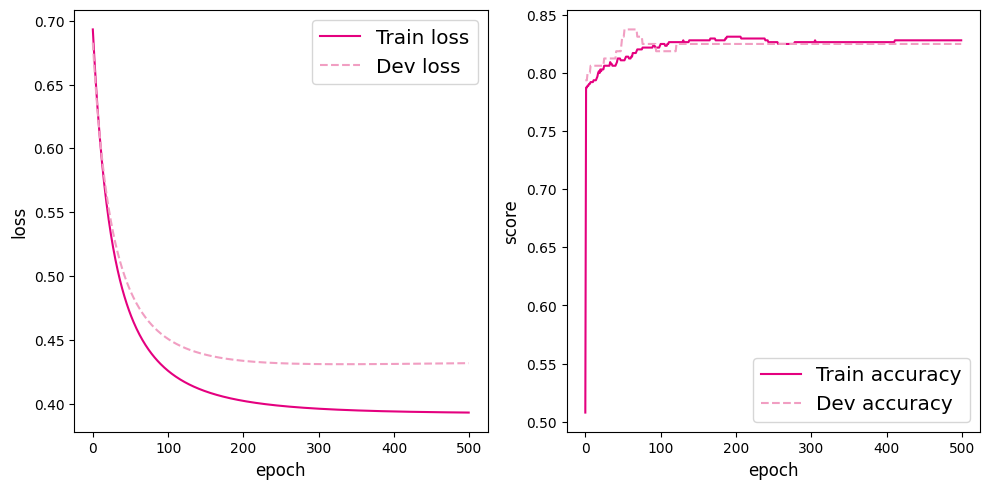

In [24]:
# 可视化观察训练集与验证集的指标变化情况
def plot(runner, fig_name):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    epochs = [i for i in range(len(runner.train_scores))]
    # 绘制训练损失变化曲线
    plt.plot(epochs, runner.train_loss, color='#e4007f', label="Train loss")
    # 绘制评价损失变化曲线
    plt.plot(epochs, runner.dev_loss, color='#f19ec2', linestyle='--', label="Dev loss")
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize='large')
    plt.xlabel("epoch", fontsize='large')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.subplot(1,2,2)
    # 绘制训练准确率变化曲线
    plt.plot(epochs, runner.train_scores, color='#e4007f', label="Train accuracy")
    # 绘制评价准确率变化曲线
    plt.plot(epochs, runner.dev_scores, color='#f19ec2', linestyle='--', label="Dev accuracy")
    # 绘制坐标轴和图例
    plt.ylabel("score", fontsize='large')
    plt.xlabel("epoch", fontsize='large')
    plt.legend(loc='lower right', fontsize='x-large')
    plt.tight_layout()
    plt.savefig(fig_name)
    plt.show()

plot(runner,fig_name='linear-acc.pdf')

从输出结果可以看到，在训练集与验证集上，loss得到了收敛，同时准确率指标都达到了较高的水平，训练比较充分。

### 3.1.8 模型评价

使用测试集对训练完成后的最终模型进行评价，观察模型在测试集上的准确率和loss数据。代码实现如下：

In [25]:
score, loss = runner.evaluate([X_test, y_test]) # 用evaluate的话，测试集的score和loss都会存下来。如果后面没再可视化或训练的话就么问题
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.7350/0.4971


可视化观察拟合的决策边界 $\boldsymbol{X} \boldsymbol{w} + b=0$。

In [26]:
def decision_boundary(w, b, x1):
    w1, w2 = w
    x2 = (- w1 * x1 - b) / w2
    return x2

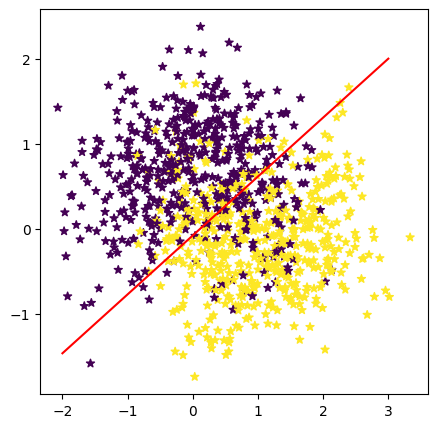

In [27]:
plt.figure(figsize=(5,5))
# 绘制原始数据
plt.scatter(X[:, 0].tolist(), X[:, 1].tolist(), marker='*', c=y.tolist())

w = model.params['w']
b = model.params['b']
x1 = paddle.linspace(-2, 3, 1000)
x2 = decision_boundary(w, b, x1)
# 绘制决策边界
plt.plot(x1.tolist(), x2.tolist(), color="red")
plt.show()

## 3.2 基于Softmax回归的多分类任务

Logistic回归可以有效地解决二分类问题，但在分类任务中，还有一类多分类问题，即类别数$C$大于2 的分类问题。Softmax回归就是Logistic回归在多分类问题上的推广。

使用Softmax回归模型对一个简单的数据集进行多分类实验。

### 3.2.1 数据集构建

我们首先构建一个简单的多分类任务，并构建训练集、验证集和测试集。
本任务的数据来自3个不同的簇，每个簇对一个类别。我们采集1000条样本，每个样本包含2个特征。

数据集的构建函数`make_multi`的代码实现如下：

In [28]:
import numpy as np
import paddle

def make_multiclass_classification(n_samples=100, n_features=2, n_classes=3, shuffle=True, noise=0.1):
    """
    生成带噪音的多类别数据
    输入：
        - n_samples：数据量大小，数据类型为int
        - n_features：特征数量，数据类型为int
        - shuffle：是否打乱数据，数据类型为bool
        - noise：以多大的程度增加噪声，数据类型为None或float，noise为None时表示不增加噪声
    输出：
        - X：特征数据，shape=[n_samples,2]
        - y：标签数据, shape=[n_samples,1]
    """
    # 计算每个类别的样本数量
    n_samples_per_class = [int(n_samples / n_classes) for k in range(n_classes)]
    for i in range(n_samples - sum(n_samples_per_class)):
        n_samples_per_class[i % n_classes] += 1
    # 将特征和标签初始化为0
    X = paddle.zeros([n_samples, n_features])
    y = paddle.zeros([n_samples], dtype='int32')
    # 随机生成3个簇中心作为类别中心
    centroids = paddle.randperm(2 ** n_features)[:n_classes]
    centroids_bin = np.unpackbits(centroids.numpy().astype('uint8')).reshape((-1, 8))[:, -n_features:]
    centroids = paddle.to_tensor(centroids_bin, dtype='float32')
    # 控制簇中心的分离程度
    centroids = 1.5 * centroids - 1
    # 随机生成特征值
    X[:, :n_features] = paddle.randn(shape=[n_samples, n_features])

    stop = 0
    # 将每个类的特征值控制在簇中心附近
    for k, centroid in enumerate(centroids):
        start, stop = stop, stop + n_samples_per_class[k]
        # 指定标签值
        y[start:stop] = k % n_classes
        X_k = X[start:stop, :n_features]
        # 控制每个类别特征值的分散程度
        A = 2 * paddle.rand(shape=[n_features, n_features]) - 1
        X_k[...] = paddle.matmul(X_k, A)
        X_k += centroid
        X[start:stop, :n_features] = X_k

    # 如果noise不为None，则给特征加入噪声
    if noise > 0.0:
        # 生成noise掩膜，用来指定给那些样本加入噪声
        noise_mask = paddle.rand([n_samples]) < noise
        for i in range(len(noise_mask)):
            if noise_mask[i]:
                # 给加噪声的样本随机赋标签值
                y[i] = paddle.randint(n_classes, shape=[1]).astype('int32')
    # 如果shuffle为True，将所有数据打乱
    if shuffle:
        idx = paddle.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]

    return X, y

随机采集1000个样本，并进行可视化。

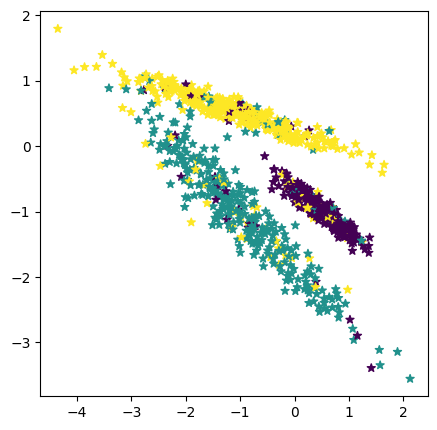

In [29]:
# 固定随机种子，保持每次运行结果一致
paddle.seed(102)
# 采样1000个样本
n_samples = 1000
X, y = make_multiclass_classification(n_samples=n_samples, n_features=2, n_classes=3, noise=0.2)

# 可视化生产的数据集，不同颜色代表不同类别
plt.figure(figsize=(5,5))
plt.scatter(x=X[:, 0].tolist(), y=X[:, 1].tolist(), marker='*', c=y.tolist())
plt.savefig('linear-dataset-vis2.pdf')
plt.show()

将实验数据拆分成训练集、验证集和测试集。其中训练集640条、验证集160条、测试集200条。

In [30]:
num_train = 640
num_dev = 160
num_test = 200

X_train, y_train = X[:num_train], y[:num_train]
X_dev, y_dev = X[num_train:num_train + num_dev], y[num_train:num_train + num_dev]
X_test, y_test = X[num_train + num_dev:], y[num_train + num_dev:]

# 打印X_train和y_train的维度
print("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)

X_train shape:  [640, 2] y_train shape:  [640]


这样，我们就完成了Multi1000数据集的构建。

In [29]:
# 打印前5个数据的标签
print(y_train[:5])

Tensor(shape=[5], dtype=int32, place=CUDAPlace(0), stop_gradient=True,
       [2, 0, 1, 0, 2])


### 3.2.2 模型构建

在Softmax回归中，对类别进行预测的方式是预测输入属于每个类别的条件概率。与Logistic 回归不同的是，Softmax回归的输出值个数等于类别数$C$，而每个类别的概率值则通过Softmax函数进行求解。

#### 3.2.2.1 Softmax函数

Softmax函数可以将多个标量映射为一个概率分布。对于一个$K$维向量，$\mathbf x=[x_1,\cdots,x_K]$，Softmax的计算公式为

$$
\mathrm{softmax}(x_k) = \frac{\exp(x_k)}{\sum_{i=1}^K \exp(x_i)}。（3.11）
$$

在Softmax函数的计算过程中，要注意**上溢出**和**下溢出**的问题。假设Softmax 函数中所有的$x_k$都是相同大小的数值$a$，理论上，所有的输出都应该为$\frac{1}{k}$。但需要考虑如下两种特殊情况：

* $a$为一个非常大的负数，此时$\exp(a)$ 会发生下溢出现象。计算机在进行数值计算时，当数值过小，会被四舍五入为0。此时，Softmax函数的分母会变为0，导致计算出现问题；
* $a$为一个非常大的正数，此时会导致$\exp(a)$发生上溢出现象，导致计算出现问题。

为了解决上溢出和下溢出的问题，在计算Softmax函数时，可以使用$x_k - \max(\mathbf x)$代替$x_k$。 此时，通过减去最大值，$x_k$最大为0，避免了上溢出的问题；同时，分母中至少会包含一个值为1的项，从而也避免了下溢出的问题。

Softmax函数的代码实现如下：

In [31]:
# x为tensor
def softmax(X):
    """
    输入：
        - X：shape=[N, C]，N为向量数量，C为向量维度
    """
    x_max = paddle.max(X, axis=1, keepdim=True)#N,1
    x_exp = paddle.exp(X - x_max)
    partition = paddle.sum(x_exp, axis=1, keepdim=True)#N,1
    return x_exp / partition

# 观察softmax的计算方式
X = paddle.to_tensor([[0.1, 0.2, 0.3, 0.4],[1,2,3,4]])
predict = softmax(X)
print(predict)

Tensor(shape=[2, 4], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.21383820, 0.23632778, 0.26118261, 0.28865141],
        [0.03205860, 0.08714432, 0.23688284, 0.64391422]])


#### 3.2.2.2 Softmax回归算子

在Softmax回归中，类别标签$y\in\{1,2,…,C\}$。给定一个样本$\mathbf x$，使用Softmax回归预测的属于类别$c$的条件概率为

$$
\begin{aligned}
p(y=c|\mathbf x) &= \mathrm{softmax}(\mathbf w_c^T \mathbf x+b_c)，（3.12）
\end{aligned}
$$

其中$\mathbf w_c$是第 $c$ 类的权重向量，$b_c$是第 $c$ 类的偏置。

Softmax回归模型其实就是线性函数与Softmax函数的组合。

将$N$个样本归为一组进行成批地预测。

$$
\hat{\mathbf Y} = \mathrm{softmax}(\boldsymbol{X} \boldsymbol{W} + \mathbf b), (3.13)
$$

其中$\boldsymbol{X}\in \mathbb{R}^{N\times D}$为$N$个样本的特征矩阵，$\boldsymbol{W}=[\mathbf w_1,……,\mathbf w_C]$为$C$个类的权重向量组成的矩阵，$\hat{\mathbf Y}\in \mathbb{R}^{C}$为所有类别的预测条件概率组成的矩阵。

我们根据公式（3.13）实现Softmax回归算子，代码实现如下：

In [32]:
class model_SR(op.Op):
    def __init__(self, input_dim, output_dim):
        super(model_SR, self).__init__()
        self.params = {}
        # 将线性层的权重参数全部初始化为0
        self.params['W'] = paddle.zeros(shape=[input_dim, output_dim])
        # self.params['W'] = paddle.normal(mean=0, std=0.01, shape=[input_dim, output_dim])
        # 将线性层的偏置参数初始化为0
        self.params['b'] = paddle.zeros(shape=[output_dim])
        self.outputs = None

    def __call__(self, inputs):
        return self.forward(inputs)

    def forward(self, inputs):
        """
        输入：
            - inputs: shape=[N,D], N是样本数量，D是特征维度
        输出：
            - outputs：预测值，shape=[N,C]，C是类别数
        """
        # 线性计算
        score = paddle.matmul(inputs, self.params['W']) + self.params['b']
        # Softmax 函数
        self.outputs = softmax(score)
        return self.outputs

# 随机生成1条长度为4的数据
inputs = paddle.randn(shape=[1,4])
print('Input is:', inputs)
# 实例化模型，这里令输入长度为4，输出类别数为3
model = model_SR(input_dim=4, output_dim=3)
outputs = model(inputs)
print('Output is:', outputs)

Input is: Tensor(shape=[1, 4], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[ 1.52324808,  0.26465878, -0.12106060, -1.08118045]])
Output is: Tensor(shape=[1, 3], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.33333334, 0.33333334, 0.33333334]])


从输出结果可以看出，采用全0初始化后，属于每个类别的条件概率均为$\frac{1}{C}$。这是因为，不论输入值的大小为多少，线性函数$f(\mathbf x;\mathbf W,\mathbf b)$的输出值恒为0。此时，再经过Softmax函数的处理，每个类别的条件概率恒等。

### 3.2.3 损失函数

Softmax回归同样使用交叉熵损失作为损失函数，并使用梯度下降法对参数进行优化。通常使用$C$维的one-hot类型向量$\mathbf y \in \{0,1\}^C$来表示多分类任务中的类别标签。对于类别$c$，其向量表示为：

$$
\mathbf y = [I(1=c),I(2=c),…,I(C=c)]^T，（3.14）
$$

其中$I(·)$是指示函数，即括号内的输入为“真”，$I(·)=1$；否则，$I(·)=0$。

给定有$N$个训练样本的训练集$\{(\mathbf x^{(n)},y^{(n)})\} ^N_{n=1}$，令$\hat{\mathbf y}^{(n)}=\mathrm{softmax}(\mathbf W^ \mathrm{ T } \mathbf x^{(n)}+\mathbf b)$为样本$\mathbf x^{(n)}$在每个类别的后验概率。多分类问题的交叉熵损失函数定义为：

$$
\cal R(\mathbf W,\mathbf b) = -\frac{1}{N}\sum_{n=1}^N (\mathbf y^{(n)})^ \mathrm{ T } \log\hat{\mathbf y}^{(n)} = -\frac{1}{N}\sum_{n=1}^N \sum_{c=1}^C \mathbf y_c^{(n)} \log\hat{\mathbf y}_c^{(n)}.（3.15）
$$

观察上式，$\mathbf y_c^{(n)}$在$c$为真实类别时为1，其余都为0。也就是说，交叉熵损失只关心正确类别的预测概率，因此，上式又可以优化为：

$$
\cal R(\mathbf W,\mathbf b) = -\frac{1}{N}\sum_{n=1}^N \log [\hat{\mathbf y}^{(n)}]_{y^{(n)}},（3.16）
$$

其中$y^{(n)}$是第$n$个样本的标签。

因此，多类交叉熵损失函数的代码实现如下：

In [33]:
class MultiCrossEntropyLoss(op.Op):
    def __init__(self):
        self.predicts = None
        self.labels = None
        self.num = None

    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)

    def forward(self, predicts, labels):
        """
        输入：
            - predicts：预测值，shape=[N, 1]，N为样本数量
            - labels：真实标签，shape=[N, 1]
        输出：
            - 损失值：shape=[1]
        """
        self.predicts = predicts
        self.labels = labels
        self.num = self.predicts.shape[0]
        loss = 0
        for i in range(0, self.num):
            index = self.labels[i]
            loss -= paddle.log(self.predicts[i][index])
        return loss / self.num

# 测试一下
# 假设真实标签为第1类
labels = paddle.to_tensor([0])
# 计算风险函数
mce_loss = MultiCrossEntropyLoss()
print(mce_loss(outputs, labels))

Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [1.09861231])


### 3.2.4 模型优化

使用梯度下降法进行参数学习。

#### 3.2.4.1 梯度计算

计算风险函数$\cal R(\mathbf W,\mathbf b)$关于参数$\mathbf W$和$\mathbf b$的偏导数。在Softmax回归中，计算方法为：

$$
\frac{\partial \cal R(\mathbf W,\mathbf b)}{\partial \mathbf W} = -\frac{1}{N}\sum_{n=1}^N \mathbf x^{(n)}(y^{(n)}- \hat{ y}^{(n)})^T = -\frac{1}{N} \mathbf X^ \mathrm{ T } (\mathbf y- \hat{\mathbf y}),（3.17）
$$

$$
\frac{\partial \cal R(\mathbf W,\mathbf b)}{\partial \mathbf b} = -\frac{1}{N}\sum_{n=1}^N (y^{(n)}- \hat{y}^{(n)})^T = -\frac{1}{N} \mathbf 1 (\mathbf y- \hat{\mathbf y}).（3.18）
$$

其中$\mathbf X\in \mathbb{R}^{N\times D}$为$N$个样本组成的矩阵，$\mathbf y\in \mathbb{R}^{N}$为$N$个样本标签组成的向量，$\hat{\mathbf y}\in \mathbb{R}^{N}$为$N$个样本的预测标签组成的向量，$\mathbf{1}$为$N$维的全1向量。

将上述计算方法定义在模型的`backward`函数中，代码实现如下：

In [34]:
class model_SR(op.Op):
    def __init__(self, input_dim, output_dim):
        super(model_SR, self).__init__()
        self.params = {}
        # 将线性层的权重参数全部初始化为0
        self.params['W'] = paddle.zeros(shape=[input_dim, output_dim])
        # self.params['W'] = paddle.normal(mean=0, std=0.01, shape=[input_dim, output_dim])
        # 将线性层的偏置参数初始化为0
        self.params['b'] = paddle.zeros(shape=[output_dim])
        # 存放参数的梯度
        self.grads = {}
        self.X = None
        self.outputs = None
        self.output_dim = output_dim

    def __call__(self, inputs):
        return self.forward(inputs)

    def forward(self, inputs):
        self.X = inputs
        # 线性计算
        score = paddle.matmul(self.X, self.params['W']) + self.params['b']
        # Softmax 函数
        self.outputs = softmax(score)
        return self.outputs

    def backward(self, labels):
        """
        输入：
            - labels：真实标签，shape=[N, 1]，其中N为样本数量
        """
        # 计算偏导数
        N =labels.shape[0]
        labels = paddle.nn.functional.one_hot(labels, self.output_dim)
        self.grads['W'] = -1 / N * paddle.matmul(self.X.t(), (labels-self.outputs))
        self.grads['b'] = -1 / N * paddle.matmul(paddle.ones(shape=[N]), (labels-self.outputs))

#### 3.2.4.2 参数更新

在计算参数的梯度之后，我们使用3.1.4.2中实现的梯度下降法进行参数更新。

### 3.2.5 模型训练

实例化RunnerV2类，并传入训练配置。使用训练集和验证集进行模型训练，共训练500个epoch。每隔50个epoch打印训练集上的指标。代码实现如下：

best accuracy performence has been updated: 0.00000 --> 0.71250
[Train] epoch: 0, loss: 1.098615050315857, score: 0.35625001788139343
[Dev] epoch: 0, loss: 1.07489812374115, score: 0.7125000357627869
best accuracy performence has been updated: 0.71250 --> 0.71875
best accuracy performence has been updated: 0.71875 --> 0.73125
best accuracy performence has been updated: 0.73125 --> 0.73750
best accuracy performence has been updated: 0.73750 --> 0.74375
best accuracy performence has been updated: 0.74375 --> 0.75000
best accuracy performence has been updated: 0.75000 --> 0.75625
best accuracy performence has been updated: 0.75625 --> 0.76250
best accuracy performence has been updated: 0.76250 --> 0.76875
best accuracy performence has been updated: 0.76875 --> 0.77500
best accuracy performence has been updated: 0.77500 --> 0.78125
best accuracy performence has been updated: 0.78125 --> 0.78750
[Train] epoch: 100, loss: 0.7335196733474731, score: 0.7843749523162842
[Dev] epoch: 100, loss: 

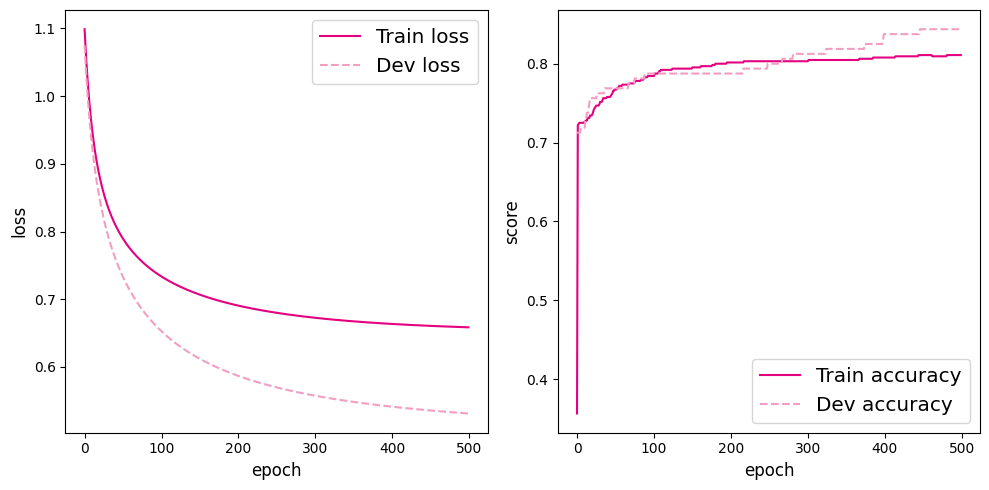

In [35]:
# 固定随机种子，保持每次运行结果一致
paddle.seed(102)

# 特征维度
input_dim = 2
# 类别数
output_dim = 3
# 学习率
lr = 0.1

# 实例化模型
model = model_SR(input_dim=input_dim, output_dim=output_dim)
# 指定优化器
optimizer = SimpleBatchGD(init_lr=lr, model=model)
# 指定损失函数
loss_fn = MultiCrossEntropyLoss()
# 指定评价方式
metric = accuracy
# 实例化RunnerV2类
runner = RunnerV2(model, optimizer, metric, loss_fn)

# 模型训练
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=500, log_eopchs=50, eval_epochs=1, save_path="best_model.pdparams")

# 可视化观察训练集与验证集的准确率变化情况
plot(runner,fig_name='linear-acc2.pdf')

### 3.2.6 模型评价

使用测试集对训练完成后的最终模型进行评价，观察模型在测试集上的准确率。代码实现如下：

In [36]:
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.8400/0.5562


可视化观察类别划分结果。

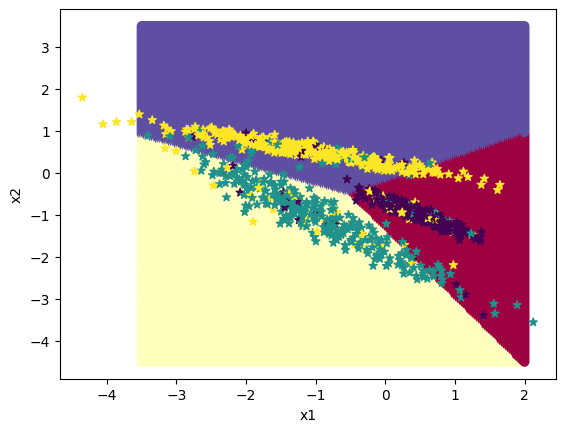

In [37]:
# 均匀生成40000个数据点
x1, x2 = paddle.meshgrid(paddle.linspace(-3.5, 2, 200), paddle.linspace(-4.5, 3.5, 200))
x = paddle.stack([paddle.flatten(x1), paddle.flatten(x2)], axis=1)
# 预测对应类别
y = runner.predict(x)
y = paddle.argmax(y, axis=1)
# 绘制类别区域
plt.ylabel('x2')
plt.xlabel('x1')
plt.scatter(x[:,0].tolist(), x[:,1].tolist(), c=y.tolist(), cmap=plt.cm.Spectral)

paddle.seed(102)
n_samples = 1000
X, y = make_multiclass_classification(n_samples=n_samples, n_features=2, n_classes=3, noise=0.2)

plt.scatter(X[:, 0].tolist(), X[:, 1].tolist(), marker='*', c=y.tolist())

**********

**拓展**

提前停止是在使用梯度下降法进行模型优化时常用的正则化方法。对于某些拟合能力非常强的机器学习算法，当训练轮数较多时，容易发生过拟合现象，即在训练集上错误率很低，但是在未知数据（或测试集）上错误率很高。为了解决这一问题，通常会在模型优化时，使用验证集上的错误代替期望错误。当验证集上的错误率不在下降时，就停止迭代。

在3.4.3节的实验中，模型训练过程中会按照提前停止的思想保存验证集上的最优模型。

**********